In [1]:
Names = 'Titus Jungao and Jude Teves'

In [2]:
from sklearn.neighbors import KNeighborsRegressor

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

Bike Sharing dataset

In [3]:
df_bikesharing = pd.read_csv('Bike_Sharing_hour.csv')

dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

for each in dummy_fields:
    dummies = pd.get_dummies(df_bikesharing[each], prefix=each, drop_first=False)
    df_bikesharing = pd.concat([df_bikesharing, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr',
                  'casual', 'registered'
                 ]

dummy = df_bikesharing.drop(fields_to_drop, axis=1)
dummy.head()

,yr,holiday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,16,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,40,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,32,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,13,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
dummy.shape

(17379, 57)

In [21]:
dummy.columns

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'cnt', 'season_1',
       'season_2', 'season_3', 'season_4', 'weathersit_1', 'weathersit_2',
       'weathersit_3', 'weathersit_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11',
       'mnth_12', 'hr_0', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6',
       'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14',
       'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22',
       'hr_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

df_features=dummy.drop('cnt', axis=1)
len(df_features)
df_features.head(5)

X = df_features
y = dummy['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

y_train = np.array(y_train, ndmin=2).T
y_test = np.array(y_test, ndmin=2).T

scalerX = StandardScaler()
# scalerX = MinMaxScaler()

X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)

## Implement NN

In [4]:
from sklearn.metrics import r2_score

class NN():
    
    def __init__(self, layers, activations, gamma):
        self.layers = layers
        self.activations = activations
        self.gamma = gamma
        self.cache = {}
        
        np.random.seed(42)
        self.weights = {}
        w = 0.001
        #w = 1
        for i in range(1,len(self.layers)):
            self.weights['w'+str(i)] = w*(2*np.random.random((self.layers[i], self.layers[i-1]))-1)
             
    def forward_propagation(self, X):
        self.cache = {}
        layer_curr = X.T
        self.cache['a0'] = layer_curr
        
        for i in range(1, len(self.layers)):
            layer_pre = self.weights['w'+str(i)].dot(layer_curr)
            self.cache['a'+str(i)] = layer_pre
            layer_curr = self.activations[i](layer_pre)
            
        #print('Forward prop final shape: ', layer_curr.shape)
        return layer_curr
    
    def backward_propagation(self, error):
        layer_error = error
        for i in range(1, len(self.layers))[::-1]:
            layer_curr = self.cache['a'+str(i)]
            layer_pre = self.cache['a'+str(i-1)]
            if i != len(self.layers)-1:
                layer_error = self.weights['w'+str(i+1)].T.dot(layer_error)
            layer_error = layer_error*self.activations[i](layer_curr, deriv=True)
            self.weights['w'+str(i)] -= self.gamma * layer_error.dot(self.activations[i-1](layer_pre.T))
            
    def compute(self, X, y, X_test, y_test, iterations, metric):
        y = y.reshape(1, -1)
        y_test = y_test.reshape(1, -1)
        
        error_history = []
        error_history_test = []
        accs_train = []
        accs_test = []
        
        for i in range(iterations):
            
            #test
            y_pred = self.forward_propagation(X_test)
            y_pred = y_pred.reshape(1, -1)
            error = y_pred - y_test
            error_history_test.append(np.mean(abs(error), axis=1))
            
            #test accuracy
            acc = metric(y_pred, y_test)
            accs_test.append(acc)

            #train
            y_pred = self.forward_propagation(X)
            y_pred = y_pred.reshape(1, -1)
            #print(y_pred)
            error = y_pred - y
            error_history.append(np.mean(abs(error), axis=1))
            
            #train accuracy
            acc = metric(y_pred, y)
            accs_train.append(acc)
            
            self.backward_propagation(error)
        
        return error_history, error_history_test, accs_train, accs_test

In [32]:
class Activation():
    def get(self, type):
        if type == 'linear':
              return self.linear
        elif type == 'sigmoid':
              return self.sigmoid
        elif type == 'sine':
              return self.sine
        elif type == 'tanh':
              return self.tanh
        elif type == 'relu':
              return self.relu
            
    @staticmethod
    def linear(x, deriv=False):
        if(deriv==True):
            return 1
        return x
            
    @staticmethod
    def sigmoid(x, deriv=False):
        sigmoid = 1/(1+np.exp(-x))
        if(deriv==True):
            return sigmoid*(1-sigmoid)
        return sigmoid
    
    @staticmethod
    def sine(x, deriv=False):
        if(deriv==True):
            return np.cos(x)
        return np.sin(x)
    
    @staticmethod
    def tanh(x, deriv=False):
        if(deriv==True):
            return 1-np.tanh(x)**2
        return np.tanh(x)
    
    @staticmethod
    def relu(x, deriv=False):
        if(deriv==True):
            return x>0
        return x*(x>0)
    
class EvaluationMetric():
    def get(self, type):
        if type == 'r-squared':
            metric = lambda ypred, ytrue: max(0,r2_score(ypred.flatten(), ytrue.flatten()))
        elif type == 'mape':
            metric = lambda ypred, ytrue: np.mean(np.abs((ytrue - ypred) / ytrue))
        elif type == 'rmlse':
            metric = lambda ypred, ytrue: np.sqrt((np.log((ypred + 1)/(ytrue + 1))**2).mean())
        
        return metric
            

In [10]:
# Activation().get('sigmoid')(X)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13034, 56), (13034, 1), (4345, 56), (4345, 1))

## Using RMLSE

RMLSE cannot handle negative values. Thus, target feature must contain values from 0 to $+ \infty$.

In [41]:
act = Activation()
# first activation must be linear
activations = [act.get('linear'),act.get('relu'),act.get('linear')]

# first hidden layer is a buffer layer.
nn = NN((56,28,1),activations,0.00001)

scalerY = MinMaxScaler()
y_train_scaled = scalerY.fit_transform(y_train)
y_test_scaled = scalerY.transform(y_test)

metric = EvaluationMetric().get('rmlse')
error_hist, error_hist_test, accs_train, accs_test = nn.compute(X_train, y_train_scaled, 
                                                                X_test, y_test_scaled, 10000, metric)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


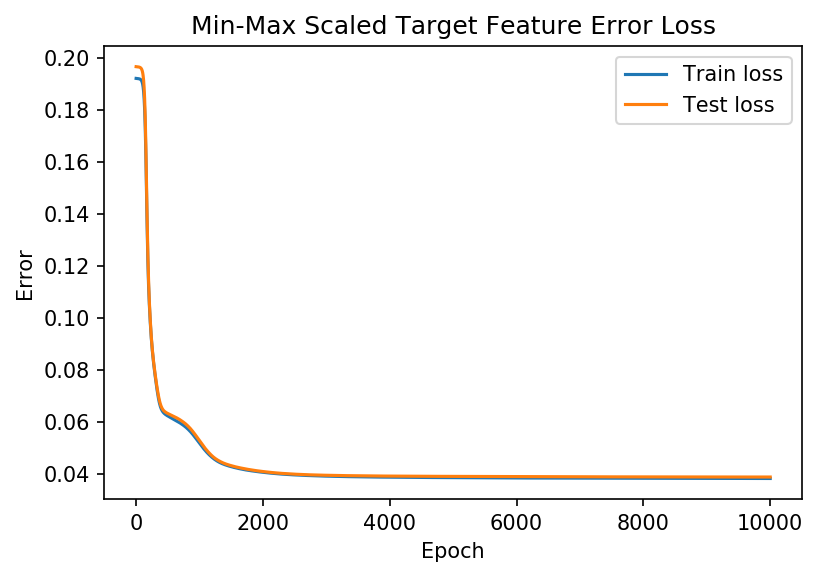

Min error rate: 4.3921% | Epoch: 9999


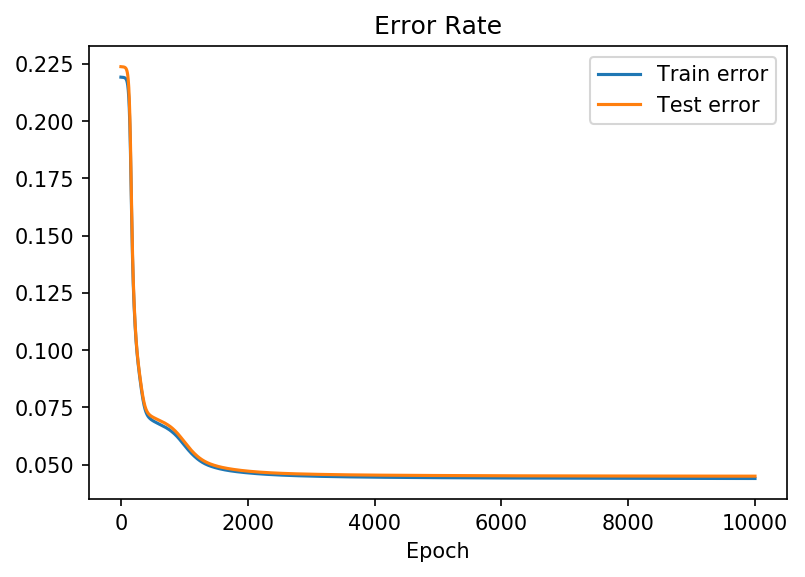

In [42]:
plt.figure(dpi=150)
plt.plot(error_hist, label='Train loss')
plt.plot(error_hist_test, label='Test loss')
plt.legend()
plt.title('Min-Max Scaled Target Feature Error Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

plt.figure(dpi=150)
print('Min error rate: {:.4%} | Epoch: {}'.format(min(accs_train), np.argmin(accs_test)))
plt.plot(accs_train, label='Train error')
plt.plot(accs_test, label='Test error')
plt.legend()
plt.title('Error Rate')
plt.xlabel('Epoch')
plt.show()

## Using MAPE

Only use MAPE if the target feature only has positive values. We would not use any scaling here because the target feature already contains only positive values.

In [43]:
act = Activation()
# first activation must be linear
activations = [act.get('linear'),act.get('relu'),act.get('linear')]

# first hidden layer is a buffer layer.
nn = NN((56,28,1),activations,0.00001)

scalerY = MinMaxScaler(feature_range=(1,2))
y_train_scaled = scalerY.fit_transform(y_train)
y_test_scaled = scalerY.transform(y_test)

metric = EvaluationMetric().get('mape')
error_hist, error_hist_test, accs_train, accs_test = nn.compute(X_train, y_train_scaled, 
                                                                X_test, y_test_scaled, 10000, metric)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


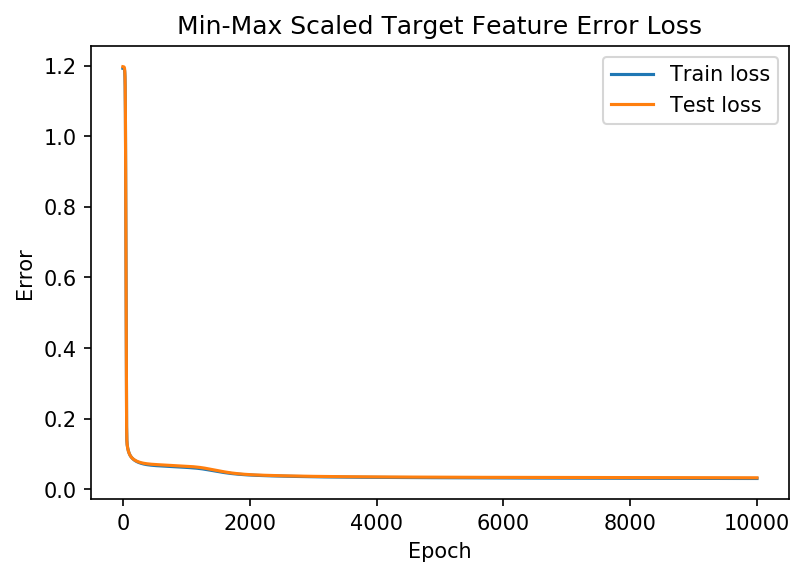

Min error rate: 2.5216% | Epoch: 9999


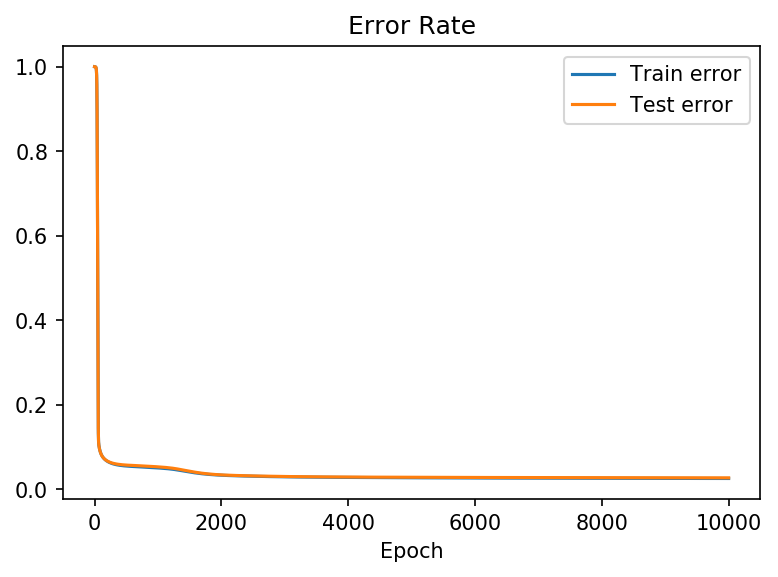

In [44]:
plt.figure(dpi=150)
plt.plot(error_hist, label='Train loss')
plt.plot(error_hist_test, label='Test loss')
plt.legend()
plt.title('Min-Max Scaled Target Feature Error Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

plt.figure(dpi=150)
print('Min error rate: {:.4%} | Epoch: {}'.format(min(accs_train), np.argmin(accs_test)))
plt.plot(accs_train, label='Train error')
plt.plot(accs_test, label='Test error')
plt.legend()
plt.title('Error Rate')
plt.xlabel('Epoch')
plt.show()

## Using R-Squared

In [37]:
act = Activation()
# first activation must be linear
activations = [act.get('linear'),act.get('relu'),act.get('linear')]

# first hidden layer is a buffer layer.
nn = NN((56,28,1),activations,0.00001)

# StandardScaler has better accuracy
scalerY = StandardScaler()
# scalerY = MinMaxScaler()

y_train_scaled = scalerY.fit_transform(y_train)
y_test_scaled = scalerY.transform(y_test)

metric = EvaluationMetric().get('r-squared')
error_hist, error_hist_test, accs_train, accs_test = nn.compute(X_train, y_train_scaled, 
                                                                X_test, y_test_scaled, 10000, metric)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


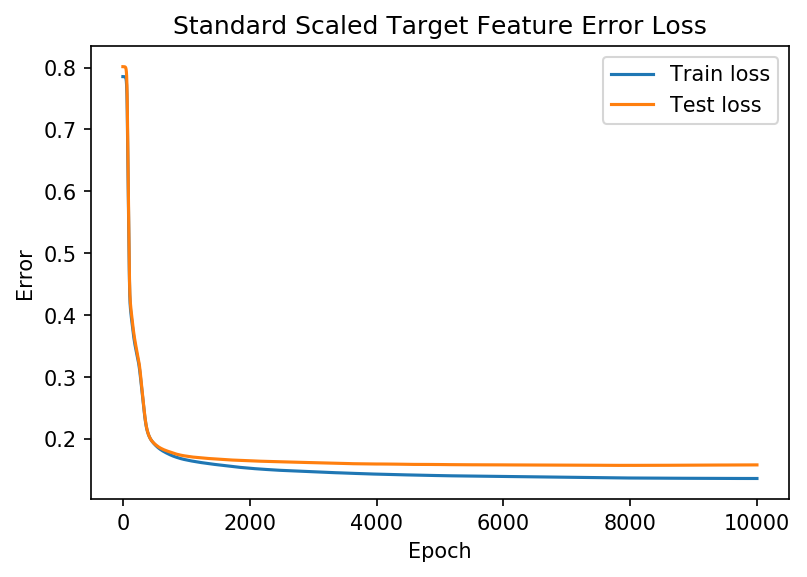

Max test accuracy: 95.5934% | Epoch: 9876


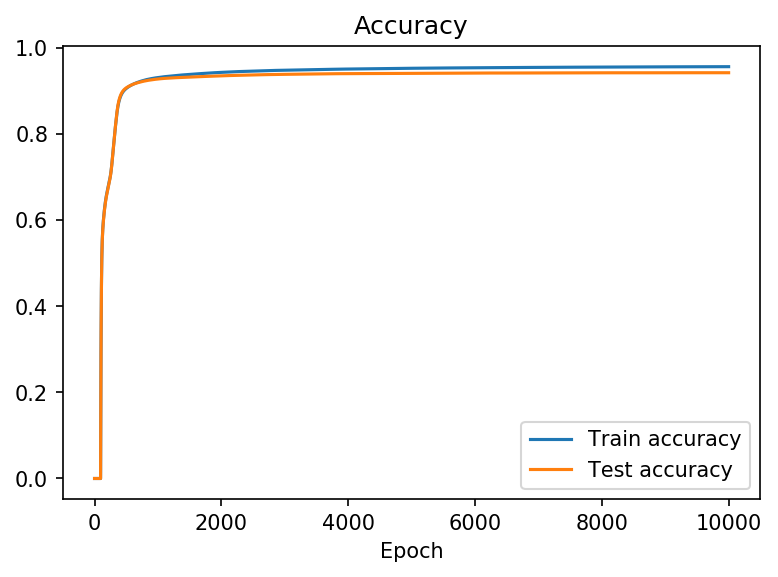

In [40]:
plt.figure(dpi=150)
plt.plot(error_hist, label='Train loss')
plt.plot(error_hist_test, label='Test loss')
plt.legend()
plt.title('Standard Scaled Target Feature Error Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

plt.figure(dpi=150)
print('Max test accuracy: {:.4%} | Epoch: {}'.format(max(accs_train), np.argmax(accs_test)))
plt.plot(accs_train, label='Train accuracy')
plt.plot(accs_test, label='Test accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Using Traditional ML techniques

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

## Default Evaluation metric

In [58]:
scores = []

model = LinearRegression().fit(X_train, y_train)
score = model.score(X_test,y_test)
scores.append(score)

model = Ridge().fit(X_train, y_train)
score = model.score(X_test,y_test)
scores.append(score)

model = Lasso(alpha=0.01).fit(X_train, y_train)
score = model.score(X_test,y_test)
scores.append(score)

model = SVR().fit(X_train, y_train)
score = model.score(X_test,y_test)
scores.append(score)

model = DecisionTreeRegressor().fit(X_train, y_train)
score = model.score(X_test,y_test)
scores.append(score)

model = RandomForestRegressor().fit(X_train, y_train)
score = model.score(X_test,y_test)
scores.append(score)

model = GradientBoostingRegressor().fit(X_train, y_train)
score = model.score(X_test,y_test)
scores.append(score)

models = ['Linear Regression', 'Ridge', 'Lasso', 'Support Vector Regressor',
          'Decision Trees', 'Random Forest', 'Gradient Boosting Regressor']
df_scores = pd.DataFrame({'Model': models, 'Test Accuracy': scores})
df_scores

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Model,Test Accuracy
0,Linear Regression,0.685522
1,Ridge,0.685541
2,Lasso,0.680328
3,Support Vector Regressor,0.934338
4,Decision Trees,0.829110
5,Random Forest,0.909546
6,Gradient Boosting Regressor,0.758132


## Using MAPE

In [81]:
model.predict(X_test).flatten().shape, y_test.ravel().shape

((4345,), (4345,))

In [85]:
np.log(-10)

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


nan

In [91]:
scores = []

#MAPE
# acc_compute = lambda ypred, ytrue: 1 - np.mean(np.abs((ytrue - ypred) / ytrue))
#RMLSE
acc_compute = lambda ypred, ytrue: 1 - np.sqrt((np.log((ypred + 1)/(ytrue + 1))**2).mean())

model = LinearRegression().fit(X_train, y_train)
score = acc_compute(model.predict(X_test).ravel(), y_test.ravel())
scores.append(score)

model = Ridge().fit(X_train, y_train)
score = acc_compute(model.predict(X_test), y_test)
scores.append(score)

model = Lasso(alpha=0.01).fit(X_train, y_train)
score = acc_compute(model.predict(X_test), y_test)
scores.append(score)

model = SVR().fit(X_train, y_train)
score = acc_compute(model.predict(X_test), y_test)
scores.append(score)

model = DecisionTreeRegressor().fit(X_train, y_train)
score = acc_compute(model.predict(X_test), y_test)
scores.append(score)

model = RandomForestRegressor().fit(X_train, y_train)
score = acc_compute(model.predict(X_test), y_test)
scores.append(score)

model = GradientBoostingRegressor().fit(X_train, y_train)
score = acc_compute(model.predict(X_test), y_test)
scores.append(score)

# models = ['Linear Regression']
models = ['Linear Regression', 'Ridge', 'Lasso', 'Support Vector Regressor',
          'Decision Trees', 'Random Forest', 'Gradient Boosting Regressor']
df_scores = pd.DataFrame({'Model': models, 'Test Accuracy': scores})
df_scores

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Model,Test Accuracy
0,Linear Regression,0.917153
1,Ridge,0.917151
2,Lasso,0.823170
3,Support Vector Regressor,0.791122
4,Decision Trees,0.791525
5,Random Forest,0.796434
6,Gradient Boosting Regressor,0.812433


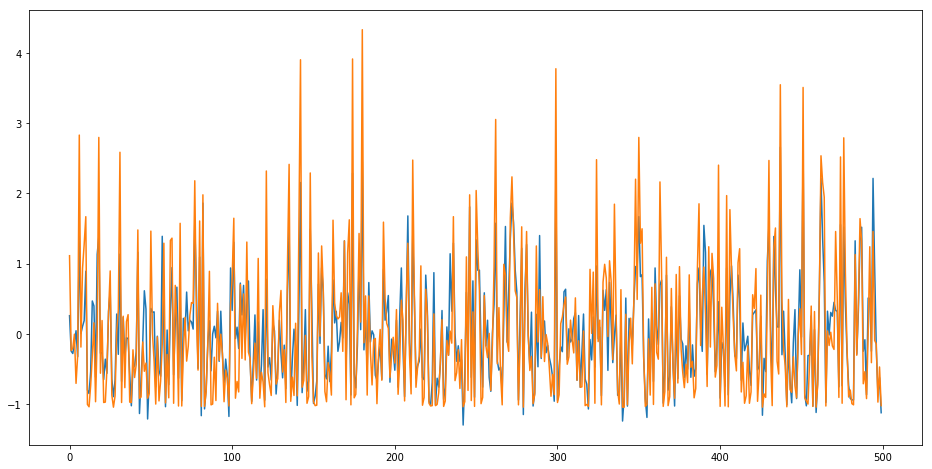

In [72]:
plt.figure(figsize=(16,8))
plt.plot(model.predict(X_test)[:500])
plt.plot(y_test[:500])